In [269]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('poster')
sns.set_style('white')
%matplotlib inline

# Simulation Data

In systematically measuring genotype-phenotype data, how will the data be collected, stored and analyzed? Is a small laptop enough to model the fold change calculations locally? I explore this in the following notebook.

In [270]:
# Set n_genotypes > 1000 to obtain estimates of variance in error as a function of num_measurements
# Set n_genotypes < 15 to obtain diagnostic plots (traceplot) and comparison of modelled to actual.
# You've been forewarned - for the diagnostics and modelled, plotting with > 100 takes a while...
n_genotypes = 2000

means = np.random.exponential(scale=0.5, size=n_genotypes)
sds = np.random.random(size=n_genotypes)
num_measurements = np.random.randint(low=2, high=9, size=n_genotypes)

# Create simulated data.
data = []
indices = []

for i in range(n_genotypes):
    n = num_measurements[i]
    mean = means[i]
    sd = sds[i]
    
    measurements = np.random.normal(loc=mean, scale=sd, size=n)
    
    data.extend(measurements.tolist())
    indices.extend([i] * n)
    
n_ctrl_measures = 15
data.extend(np.random.normal(loc=1.0, scale=0.5, size=n_ctrl_measures))
indices.extend([n_genotypes] * n_ctrl_measures)
num_measurements = np.append(num_measurements, n_ctrl_measures)
means = np.append(means, 1.0)

In [271]:
means

array([ 0.0271835 ,  0.8439903 ,  0.49684691, ...,  0.32045277,
        0.02347665,  1.        ])

In [272]:
num_measurements

array([ 5,  8,  4, ...,  6,  6, 15])

In [273]:
len(data), len(indices)

(10167, 10167)

In [274]:
with pm.Model() as model:
    # Hyperpriors
    # fold_mu = pm.Flat('fold_mu')
    # fold_sd = pm.HalfCauchy('fold_sd', 100)
    # fold_alpha = pm.Flat('fold_alpha')
    # fold_beta = pm.Flat('fold_beta')
    fold_tau = pm.HalfCauchy('fold_tau', 10)

    # "Intercept", which is basically the measurement values.
    # fold = pm.Gamma('fold', alpha=1, beta=2, shape=n_genotypes+1)
    fold = pm.HalfNormal('fold', tau=fold_tau, shape=n_genotypes+1)
    
    # Assume that data have heteroskedastic (i.e. variable) error but are drawn from the same distribution
    sigma = pm.Gamma('sigma', alpha=1, beta=1, shape=n_genotypes+1)
    
    # Model prediction
    mu = fold[indices]
    sig = sigma[indices]
    
    # Data likelihood
    like = pm.Normal('like', mu=mu, sd=sig, observed=data)

Applied log-transform to fold_tau and added transformed fold_tau_log_ to model.
Applied log-transform to fold and added transformed fold_log_ to model.
Applied log-transform to sigma and added transformed sigma_log_ to model.


In [275]:
%%time
with model:
    params = pm.variational.advi(n=200000)
    trace = pm.variational.sample_vp(params, draws=2000)

Iteration 0 [0%]: ELBO = -64698.03
Iteration 20000 [10%]: Average ELBO = -14824.03
Iteration 40000 [20%]: Average ELBO = -10354.94
Iteration 60000 [30%]: Average ELBO = -9911.03
Iteration 80000 [40%]: Average ELBO = -9838.62
Iteration 100000 [50%]: Average ELBO = -9816.24
Iteration 120000 [60%]: Average ELBO = -9815.85
Iteration 140000 [70%]: Average ELBO = -9811.21
Iteration 160000 [80%]: Average ELBO = -9812.39
Iteration 180000 [90%]: Average ELBO = -9806.08
Finished [100%]: Average ELBO = -9808.47
CPU times: user 4min 3s, sys: 2.05 s, total: 4min 5s
Wall time: 4min 8s


In [276]:
if n_genotypes <= 10:
    fig = plt.figure()
    pm.forestplot(trace, vline=1, varnames=['fold'])
    fig = plt.figure()
    pm.forestplot(trace, varnames=['sigma'])

In [277]:
if n_genotypes <= 10:
    pm.summary(trace)

In [278]:
if n_genotypes <= 10:
    pm.traceplot(trace, varnames=['fold', 'sigma'])

# Error in Estimated Mean

What is the error in estimated mean as a function of the number of measurements?

In [279]:
num_measurements

array([ 5,  8,  4, ...,  6,  6, 15])

In [280]:
trace['fold'].mean(axis=0) - means

array([ 0.22915645, -0.00117636,  0.01578248, ...,  0.22283943,
        0.14299514, -0.12522628])

In [281]:
import pandas as pd
errors_df = pd.DataFrame([num_measurements, (trace['fold'].mean(axis=0) - means)]).T
errors_df.columns = ['num_measurements', 'error_means']
errors_df.head()

,num_measurements,error_means
0,5.0,0.229156
1,8.0,-0.001176
2,4.0,0.015782
3,6.0,-0.341817
4,2.0,0.112732


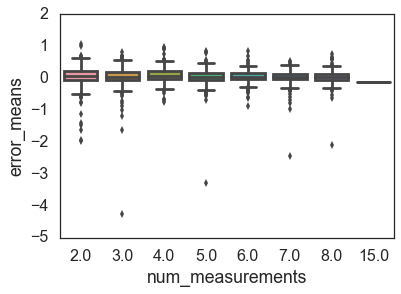

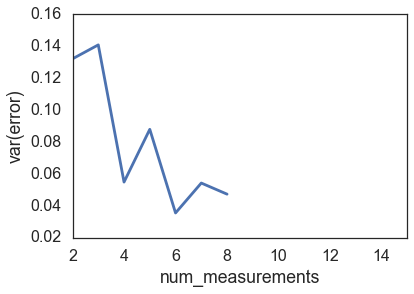

In [282]:
if n_genotypes >= 500:
    sns.boxplot(data=errors_df, x='num_measurements', y='error_means')
    errors_df.groupby('num_measurements').var().plot(legend=False)
    plt.ylabel('var(error)')

In [283]:
(trace['fold'].mean(axis=0) - means).mean()

0.047747370272495801

In [284]:
if n_genotypes <= 10:
    pm.traceplot(trace, varnames=['fold'])

# Compare modelled to actual

In [285]:
trace['fold'].mean(axis=0)

array([ 0.25633996,  0.84281394,  0.51262939, ...,  0.5432922 ,
        0.1664718 ,  0.87477372])

In [286]:
if n_genotypes <= 10:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    lower = trace['fold'].mean(axis=0) - np.percentile(trace['fold'], 2.5, axis=0)
    upper = np.percentile(trace['fold'], 97.5, axis=0) - trace['fold'].mean(axis=0)
    yerr_pos = [lower, upper]
    ax.errorbar(x=np.arange(1, n_genotypes+2), y=trace['fold'].mean(axis=0), 
                # y-error bars
                yerr=yerr_pos,
                # styling
                color='blue', ls='none', alpha=0.5, label='95% HPD',)
    ax.scatter(x=np.arange(1, n_genotypes+2), y=means, 
               # styling
               color=['red'] * 10 + ['green'], marker='o', s=100, label='actual',)
    ax.legend(loc='best', frameon=False)
    ax.hlines(xmin=0, xmax=n_genotypes+1, y=1, linestyles='--', alpha=0.2)
    ax.hlines(xmin=0, xmax=n_genotypes+1, y=0, alpha=0.2)
    ax.set_xlabel('genotype ID')
    ax.set_ylabel('fold change')
    ax.set_xlim(-2, n_genotypes+2)

In [287]:
if n_genotypes <= 10:
    fig = plt.figure()
    pm.forestplot(trace, vline=1, varnames=['fold'])
print('just for checking the above plot...')

just for checking the above plot...
